># A proof-of-concept (PoC) work for HISS waves: Statistical Independence between the magnitute of HISS waves starting with $[0.01-2] kHz$.

>- September, 2021. S. Chakraborty(<shibaji7@vt.edu>), G. S. Cunninghum

In [1]:
import os
import sys
sys.path.append("src/")
import numpy as np
import pandas as pd
import get_data as gd
import dump_data as dmap
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.colors import LogNorm
from netCDF4 import num2date

In [2]:
dates = [dt.datetime(2012,10,6) + dt.timedelta(i) for i in range(30*4)]
nds = gd.get_fetch_hiss_data(dates, "tmp/HISS_Analysis.nc")
B, freqs, L, Lstar, epoch = nds.variables["B_hiss"][:], nds.variables["freqs"][:], nds.variables["L"][:],\
                nds.variables["Lstar"][:], nds.variables["dunits"]
#os.system("rm tmp/HISS_Analysis.nc")
dunits = num2date(epoch[:], epoch.units, epoch.calendar, only_use_cftime_datetimes=False)
dunits = np.array([x._to_real_datetime() for x in dunits]).astype("datetime64[ns]")
dunits = [dt.datetime.utcfromtimestamp(x.astype(int) * 1e-9) for x in dunits]
ddates = set(dunits)

/home/shibaji/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [3]:
dmap.download_omni_dataset(dates)

tmp/EMFISIS/omni/201210.asc -to- tmp/EMFISIS/omni/201210.csv
tmp/EMFISIS/omni/201211.asc -to- tmp/EMFISIS/omni/201211.csv
tmp/EMFISIS/omni/201212.asc -to- tmp/EMFISIS/omni/201212.csv
tmp/EMFISIS/omni/201301.asc -to- tmp/EMFISIS/omni/201301.csv
tmp/EMFISIS/omni/201302.asc -to- tmp/EMFISIS/omni/201302.csv


In [4]:
omni = dmap.get_omni_dataset(dates)[["DATE", "AE"]]
omni = omni.set_index("DATE").resample("6s").interpolate().reset_index()
o = pd.DataFrame()
for d in ddates:
    o = pd.concat([o, omni[(omni.DATE>=d) & (omni.DATE<d+dt.timedelta(1))]])
omni = o.copy()
omni.head()

,DATE,AE
1699200,2013-01-27 00:00:00,317.0
1699201,2013-01-27 00:00:06,316.7
1699202,2013-01-27 00:00:12,316.4
1699203,2013-01-27 00:00:18,316.1
1699204,2013-01-27 00:00:24,315.8


In [5]:
B.shape, omni.shape

((1526400, 27), (1526400, 2))

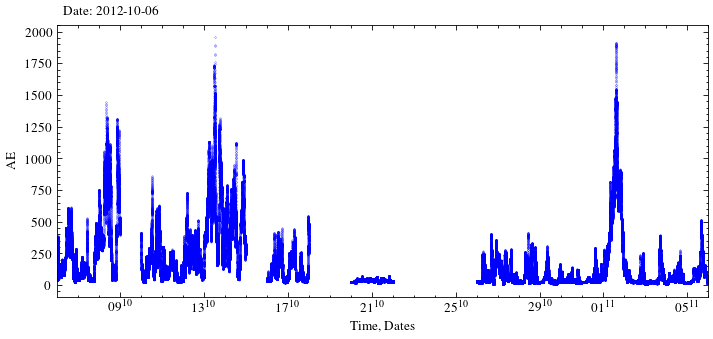

In [15]:
fig = plt.figure(dpi=120, figsize=(7,3))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(DateFormatter(r"$%d^{%m}$"))
#ax.xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 12)))
ax.plot(omni.DATE, omni.AE, "b.", ls="None", ms=0.3)
ax.set_ylabel("AE")
ax.set_xlabel("Time, Dates")
ax.set_xlim(dates[0], dates[-1]+dt.timedelta(1))
_ = ax.text(0.01, 1.05, "Date: "+dates[0].strftime("%Y-%m-%d"), ha="left", va="center", transform=ax.transAxes)

/home/shibaji/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shibaji/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


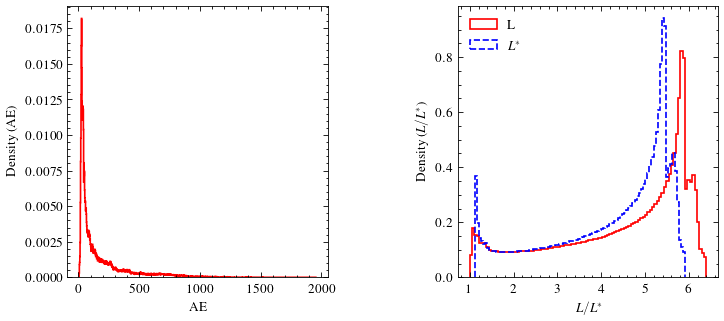

In [16]:
fig = plt.figure(dpi=120, figsize=(7,3))
ax = fig.add_subplot(121)
ax.hist(omni.AE, bins=1000, histtype="step", color="r", density=True)
ax.set_ylabel("Density (AE)")
ax.set_xlabel("AE")
ax = fig.add_subplot(122)
ax.hist(L, bins=100, histtype="step", color="r", density=True, label="L")
ax.hist(Lstar, bins=100, histtype="step", color="b", density=True, label=r"$L^*$")
ax.legend(loc=2)
ax.set_ylabel(r"Density ($L/L^*$)")
_ = ax.set_xlabel(r"$L/L^*$")
fig.subplots_adjust(wspace=0.5, hspace=0.5)

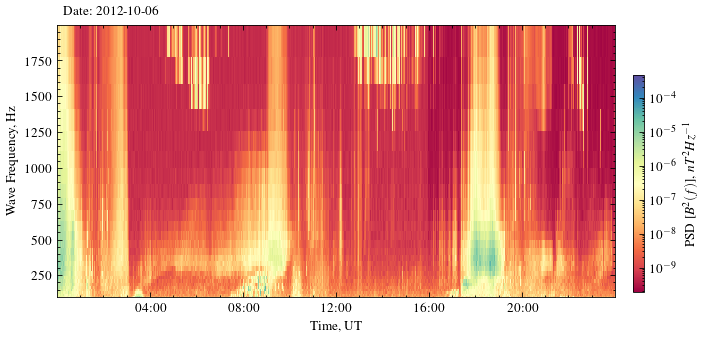

In [6]:
# fig = plt.figure(dpi=120, figsize=(6,3))
# ax = fig.add_subplot(111)
# norm = LogNorm()
# ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
# ax.xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 4)))
# ax.pcolormesh(_dic_["epoch"], _dic_["freqs"], _dic_["frames"].T,  cmap=plt.cm.Spectral, norm=norm)
# pos = ax.get_position()
# cpos = [pos.x1 + 0.025, pos.y0 + 0.0125,
#         0.015, pos.height * 0.8]                # this list defines (left, bottom, width, height
# cax = fig.add_axes(cpos)
# cb2 = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.Spectral, norm=norm, spacing="uniform", orientation="vertical")
# cb2.set_label(r"PSD [$B^2(f)$], $nT^2Hz^{-1}$")
# ax.set_xlabel("Time, UT")
# ax.text(0.01, 1.05, "Date: "+dates[0].strftime("%Y-%m-%d"), ha="left", va="center", transform=ax.transAxes)
# _=ax.set_ylabel("Wave Frequency, Hz")

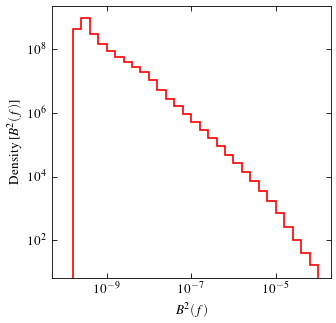

In [17]:
fig = plt.figure(dpi=120, figsize=(3,3))
ax = fig.add_subplot(111)
ax.set_ylabel(r"Density [$B^2(f)$]")
ax.set_xlabel(r"$B^2(f)$")
bins = 10**(np.linspace(-10,-4,31))
_ = ax.hist(B.ravel(), bins=bins, histtype="step", color="r", density=True)
ax.set_yscale("log")
ax.set_xscale("log")

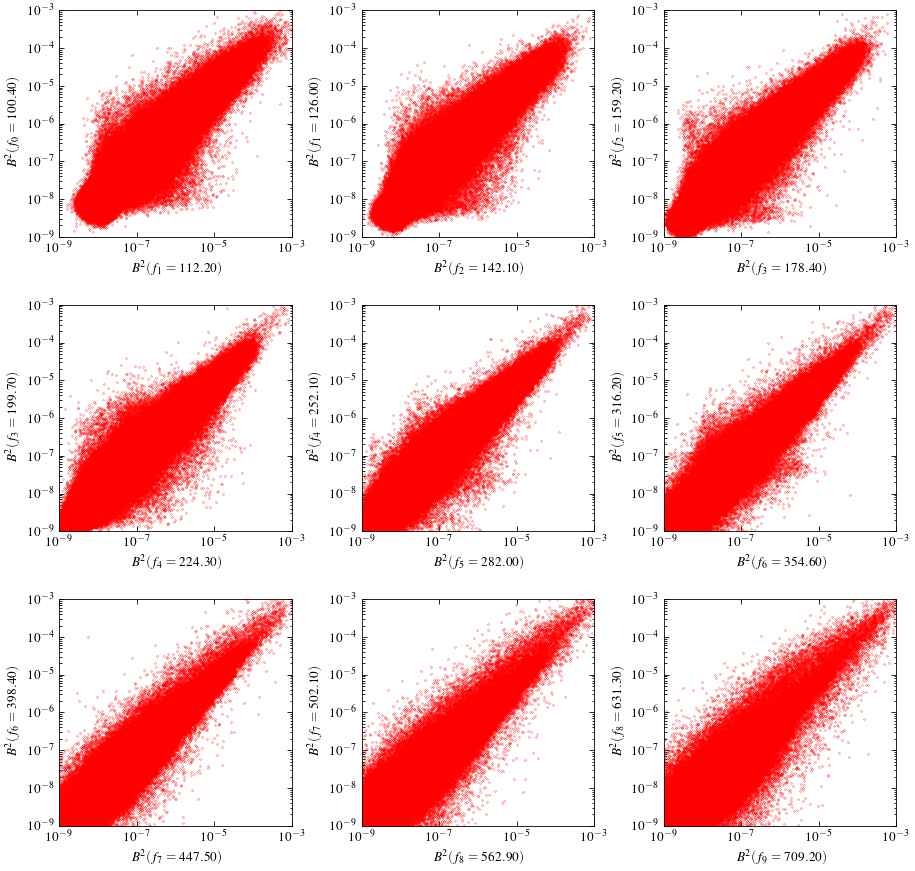

In [7]:
fig = plt.figure(dpi=120, figsize=(9,9))
for i in range(9):
    ax = fig.add_subplot(331+i)
    ax.set_ylabel(r"$B^2(f_%d=%.02f)$"%(i,freqs[2*i]))
    ax.set_xlabel(r"$B^2(f_%d=%.02f)$"%(i+1,freqs[2*i+1]))
    ax.loglog(B[:,2*i], B[:,2*i+1], "ro", ms=0.2)
    ax.set_xlim(1e-9,1e-3)
    ax.set_ylim(1e-9,1e-3)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

(1526400,) (1526400,)


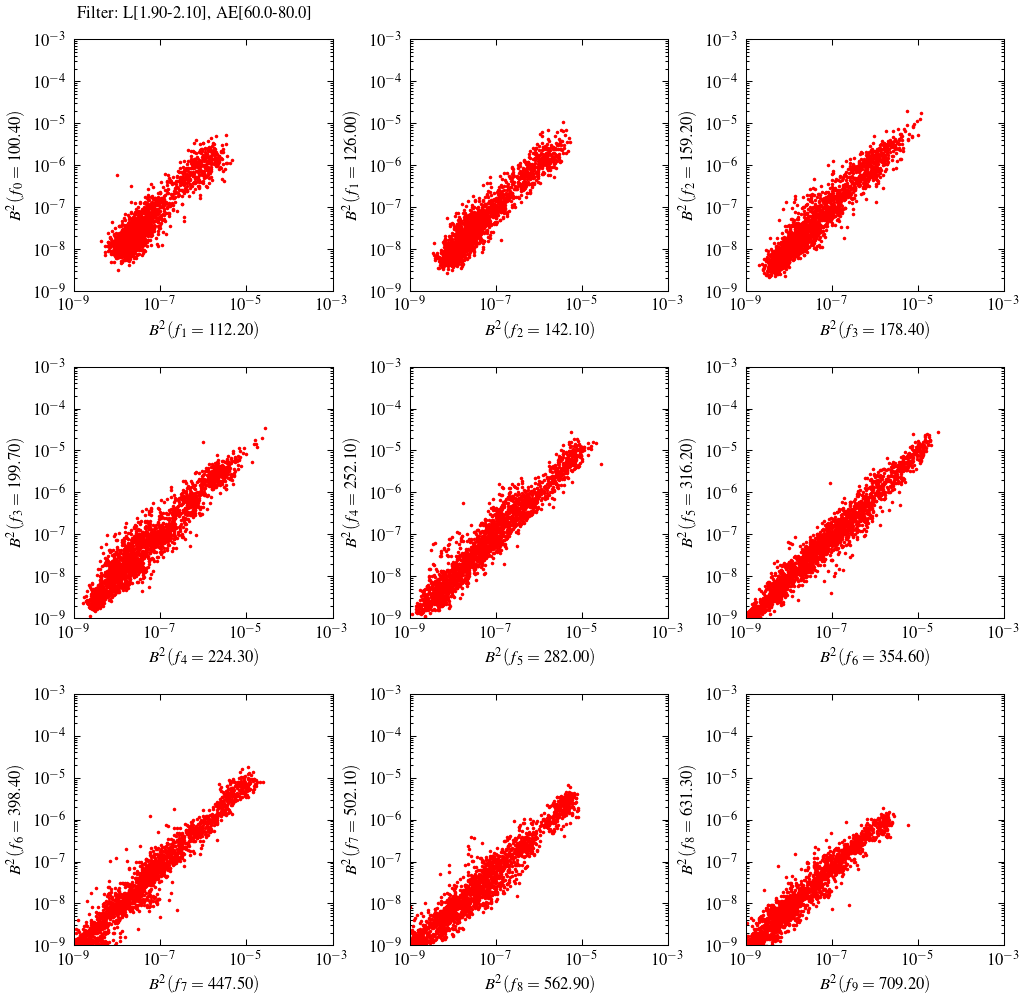

In [6]:
# Binning data based on AE and L values
AEc, dAE = 70, 20
Lc, dL = 2, 0.2
# Bin index for AE and L
AE = np.array(omni.AE)
print(AE.shape, L.shape)
i, j = 0, 0
AE_bin, L_bin = np.array([AEc-dAE/2, AEc+dAE/2]), np.array([Lc-dL/2, Lc+dL/2])
idx = (AE>=AE_bin[0]) & (AE<AE_bin[1]) & (L>=L_bin[0]) & (L<L_bin[1])
f = B[idx,:]

fig = plt.figure(dpi=150, figsize=(8,8))
for i in range(9):
    ax = fig.add_subplot(331+i)
    ax.set_ylabel(r"$B^2(f_%d=%.02f)$"%(i,freqs[2*i]))
    ax.set_xlabel(r"$B^2(f_%d=%.02f)$"%(i+1,freqs[2*i+1]))
    ax.loglog(f[:,2*i], f[:,2*i+1], "ro", ms=0.7)
    ax.set_xlim(1e-9,1e-3)
    ax.set_ylim(1e-9,1e-3)
    if i == 0: ax.text(0.01, 1.1, "Filter: L[%.2f-%.2f], AE[%.1f-%.1f]"%(L_bin[0], L_bin[1], AE_bin[0], AE_bin[1]),
                       ha="left", va="center", transform=ax.transAxes)
fig.subplots_adjust(wspace=0.3, hspace=0.3)